**Universidad Internacional de La Rioja (UNIR) - Máster Universitario en Inteligencia Artificial - Procesamiento del Lenguaje Natural** 

***
Datos del alumno (Nombre y Apellidos):

Fecha:
***

<span style="font-size: 20pt; font-weight: bold; color: #0098cd;">Trabajo: Caracterización de textos</span>

**Objetivos** 

Con esta actividad se tratará de que el alumno se familiarice con el manejo de la librería spacy, así como con los conceptos básicos de manejo de las técnicas NER

**Descripción**

En esta actividad debes procesar de forma automática un texto en lenguaje natural para detectar características básicas en el mismo, y para identificar y etiquetar las ocurrencias de conceptos como localización, moneda, empresas, etc.

En la primera parte del ejercicio se proporciona un código fuente a través del cual se lee un archivo de texto y se realiza un preprocesado del mismo. En esta parte el alumno tan sólo debe ejecutar y entender el código proporcionado.

En la segunda parte del ejercicio se plantean una serie de preguntas que deben ser respondidas por el alumno. Cada pregunta deberá responderse con un fragmento de código fuente que esté acompañado de la explicación correspondiente. Para elaborar el código solicitado, el alumno deberá visitar la documentación de la librería spacy, cuyos enlaces se proporcionarán donde corresponda.

# Parte 1: carga y preprocesamiento del texto a analizar

Observa las diferentes librerías que se están importando.

In [3]:
import pathlib
import spacy
import pandas as pd
from spacy import displacy
import csv
import es_core_news_md
import numpy as np

El siguiente código simplemente carga y preprocesa el texto. Para ello, lo primero que hace es cargar un modelo de lenguaje previamente entrenado. En este caso, se utiliza <i>es_core_news_md</i>: 

https://spacy.io/models/es#es_core_news_md


In [4]:
nlp = es_core_news_md.load()

Con este script voy a intentar eliminar la mayor cantidad de carácteres extraños del texto

In [5]:
from pathlib import Path

import pandas as pd
import re

replacements = {
    "í§": "ç", "Ã§": "ç",
    "í¼": "ü", "Ã¼": "ü",
    "Ã¡": "á", "Ã©": "é", "Ã­": "í",
    "Ã³": "ó", "Ãº": "ú",
    "Ã": "Á", "Ã‰": "É", "Ã": "Í",
    "Ã“": "Ó", "Ãš": "Ú",
    "Ã±": "ñ", "Ã‘": "Ñ",
    "â": "’", "â": "“", "â": "”",
    "â": "—", "â¦": "…",
    "â€œ": "“",
    "Â¿": "¿", "Â¡": "¡",
}

# Rutas de entrada/salida (ajustad el nombre si hace falta)

input_path = Path("02Dataset_anonimizado.csv")  # fichero original

tmp_path = Path("comentarios_sin_bytes_raros.csv")

output_path = Path("comentarios_limpio_utf8.csv")



# Algunos bytes problemáticos detectados en el archivo original

BAD_BYTES = {0xBF, 0xA1, 0xB3}  # ¿, ¡, ³ en cp1252



# 1) Eliminamos esos bytes a nivel binario

with input_path.open("rb") as f_in, tmp_path.open("wb") as f_out:

    for raw_line in f_in:

        cleaned = bytes(b for b in raw_line if b not in BAD_BYTES)

        f_out.write(cleaned)



# 2) Leemos el CSV resultante asumiendo codificación latin1 / cp1252

df = pd.read_csv(tmp_path, sep=";", encoding="latin1")



# 3) Arreglamos el "mojibake" típico (debÃ­a -> debía, etc.)

def arreglar_mojibake(s):

    if not isinstance(s, str):

        return s

    try:

        reparado = s.encode("latin1").decode("utf-8")

        return reparado

    except UnicodeError:

        return s



text_cols = df.select_dtypes(include="object").columns

for col in text_cols:

    df[col] = df[col].apply(arreglar_mojibake)

def aplicar_reemplazos(t, reemplazos): #Coge un texto y un diccionario de reemplazos
    if not isinstance(t, str):
        return t
    regex = re.compile("|".join(map(re.escape, reemplazos.keys()))) #Crea una expresión regular que busca todas las claves del diccionario
    def reemplaza(match):
        return reemplazos[match.group(0)] #Sustituye cada patron encontrado por su valor en el diccionario
    return regex.sub(reemplaza, t)

for col in text_cols:
    df[col] = df[col].apply(lambda x: aplicar_reemplazos(x, replacements)) #Aplica los reemplazos definidos en el diccionario



# 4) Guardamos ya todo en UTF-8 limpio

df.to_csv(output_path, sep=";", index=False, encoding="utf-8")




print("Archivo limpio guardado como:", output_path)

C:\Users\demonki\AppData\Local\Temp\ipykernel_25276\2410280133.py:50: DtypeWarning: Columns (6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(tmp_path, sep=";", encoding="latin1")


Archivo limpio guardado como: comentarios_limpio_utf8.csv


El objeto <i>nlp</i> permite utilizar el modelo de lenguaje cargado, de forma que se puede procesar un texto y obtenerlo en su versión preprocesada. Así, nos permite realizar las diferentes tareas. En este caso, vamos a utilizar el pipeline para hacer un preprocesamiento básico, que consiste en tokenizar el texto.

El código siguiente carga el archivo CSV (opcionalmente con un límite de líneas a leer) y genera la variable <i>data</i>, que contiene un Dataframe (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) con los datos leídos del CSV. Sin embargo, como vamos a coger una muestra de 10000 textos, si cojo los primeros del csv no va a ser una muestra representativa del dataset porque puede que justo en los 10000 primeros sean 90% sin odio y 10% con odio.

In [6]:
filename = "comentarios_limpio_utf8.csv"
data = pd.read_csv(filename, sep=';', encoding='utf-8')
lines_number = 10000
data['ODIO'] = np.where(data['INTENSIDAD']==0, 0, 1)
grupos_odio = data.groupby('ODIO')['ODIO'].count()
print(grupos_odio)

ODIO
0    562334
1     12695
Name: ODIO, dtype: int64


C:\Users\demonki\AppData\Local\Temp\ipykernel_25276\3448978248.py:2: DtypeWarning: Columns (6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filename, sep=';', encoding='utf-8')


Vemos que en el propio dataset original, la proporción de comentarios sin odio es muchisimo mayor que la de comentarios con odio. Esto para un futuro en el que se quiera predecir la carácteristica de odio en un texto, es muy malo por que estamos ante un desbalance de clases muy claro. De todas maneras, para aprender y prácticar el hacerlo, voy a construir la muestra proporcionada al dataset original. Voy a hacer una proporción del 50% de cada grupo, para tener una muestra balanceada y obtener unos buenos resultados al cálcular estadísticas.

In [7]:
data['ODIO'] = np.where(data['INTENSIDAD']==0, 0, 1)
def obtiene_muestra_proporcionada(odio):
    proporcion = 0.5 
    numero_muestra = round(proporcion * lines_number)
    return odio.sample(n=min(numero_muestra, len(odio)), random_state=42)

df_muestra = data.groupby('ODIO', group_keys=False).apply(obtiene_muestra_proporcionada)
df_muestra.to_csv('muestra_comentarios_limpio_utf8.csv', sep=';', index=False, encoding='utf-8')

C:\Users\demonki\AppData\Local\Temp\ipykernel_25276\807801205.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_muestra = data.groupby('ODIO', group_keys=False).apply(obtiene_muestra_proporcionada)


Pues ya habiendo preparado el dataset correctamente, podemos empezar la actividad

In [8]:
filename = "muestra_comentarios_limpio_utf8.csv"
data = pd.read_csv(filename, sep=';', encoding='utf-8')
len(data)
grupos_odio = data.groupby('ODIO')['ODIO'].count()
print(grupos_odio)


ODIO
0    5000
1    5000
Name: ODIO, dtype: int64


Te vendrá bien conocer la siguiente documentación:
<ul>
    <li>https://spacy.io/api/doc</li>
    <li>https://spacy.io/api/token</li>
    <li>https://spacy.io/api/morphology#morphanalysis</li>
</ul>

### Playground

Utiliza este espacio para hacer pruebas y ensayos con las variables generadas con el código previo. A modo de ejemplo, se ofrece código que realiza las siguientes tareas: 


- leer un número dado de líneas del Dataframe y generar dos listas con los valores (se pueden leer directamente del DataFrame, se muestra el ejemplo como una opción más)
- procesar el texto de cada comentario


Para procesarlo, hay utilizar el objeto <i>nlp</i> y así obtener objetos de la clase <i>Doc</i> (https://spacy.io/api/doc)

Visita la documentación de dicha clase y experimenta probando las diferentes funciones y atributos 

In [9]:
data["CONTENIDO A ANALIZAR"] = data["CONTENIDO A ANALIZAR"].astype(str).fillna('') #Me estaba dando error por que interpretaba un nulo como FLOAT y no como STRING

doc = []
value = []
for i in range(0, lines_number):
    tmp_doc = nlp(data["CONTENIDO A ANALIZAR"][i])
    doc.append(tmp_doc)
    tmp_value = data["INTENSIDAD"][i]
    value.append(tmp_value)

In [10]:
#Zona de pruebas
# print(doc[19].text) #Iterar sobre un doc
# print(doc[1].sents) #Iterar sobre las oraciones de un doc, son objetos de tipo Span
# print(doc[1].ents) #Iterar sobre las entidades reconocidas en un doc, son objetos de tipo Span
# print(doc[1].vector) #Vector del doc, es un array numpy, es la entrada principal para el modelo de regresión de intensidad
for token in doc[1]:
    print(token.text, token.lemma_, token.pos_, token.dep_, token.head.text, token.tag_) #Con esto vemos cada palabra del doc y sus características lingüísticas

el el DET det prestigio DET
prestigio prestigio NOUN iobj perdido NOUN
lo él PRON obj perdido PRON
ha haber AUX aux perdido AUX
perdido perder VERB ROOT perdido VERB
podemos poder AUX aux hace AUX
hace hacer VERB advcl perdido VERB
aí±os aí±os NOUN obj hace NOUN
. . PUNCT punct perdido PUNCT
en en ADP case peor ADP
podemos poder AUX aux peor AUX
está estar AUX cop peor AUX
lo él PRON det peor PRON
peor peor ADJ ROOT peor ADJ
de de ADP case paí­s ADP
este este DET det paí­s DET
paí­s paí­s NOUN nmod peor NOUN
. . PUNCT punct peor PUNCT


<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Pregunta 1.</span>
<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">¿Cuántos registros contiene el corpus?</span>

In [11]:
print("El corpus tiene un numero de registros de:", len(doc))


El corpus tiene un numero de registros de: 10000


<b>Incluye aquí, debajo de la línea, la explicación de tu respuesta</b>
<hr>
 

El corpus tiene un numero de registros de 10000. Realmente no era necesario obtenerlo mediante código porque ya cuando definimos el dataset anteriormente con pandas.read_csv aplicamos el parámetro de nrows con nuestra variable definida como lines_number=10000. Por lo que desde el principio nosotros obtenemos el total de 10000 registros del dataset en bruto.

<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Pregunta 2.</span>
<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">¿Cuántas palabras totales hay en los comentarios del corpus?</span>

In [12]:
# palabras = []
# for registro in doc:
#     for token in registro:
#         palabras.append(token.text)
# print(len(palabras))

palabras = []
for registro in doc:
    for token in registro:
        if token.is_space==False & token.is_punct==False & token.like_email ==False & token.like_url==False : #Tras la recomendación del profesor de no usar is_alpha y considerar los numeros como palabras también, vamos a distinguir de espacios y puntuación
            palabras.append(token.text)
print(len(palabras))

968799


<b>Incluye aquí, debajo de la línea, la explicación de tu respuesta</b>
<hr>
 

Para responder a esta pregunta, utilizo un doble bucle. Gracias a él, puedo ir recorriendo la lista doc, que contiene todos los textos que tengo que analizar. Cada elemento de doc es un texto completo; por eso, al iterar con el segundo bucle dentro de cada doc, consigo obtener las palabras individuales. Todas estas palabras las voy guardando en la lista palabras y, finalmente, uso len() para contarlas y saber cuantas hay en total. Al principio hice esto, hasta que pensé en que los token pueden ser signos de puntuación o espacios. Por esto decidí aplicar un filtro para que si el token analizado lo es se añada y si no, no.

<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Pregunta 3.</span>
<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">¿Cuál el número promedio de palabras en cada comentario?</span>

In [13]:
#El numero de palabras ya lo tendríamos calculado de antes, al igual que el total de comentarios que sabemos que son 10000. Por tanto, 
# solo haría falta dividir ambos valores para obtener el promedio de palabras por comentario.:
print(len(palabras)/lines_number)


96.8799


<b>Incluye aquí, debajo de la línea, la explicación de tu respuesta</b>
<hr>
 

Para calcular la media de palabras que hay en cada comentario, tenemos que emplear una formula simple de media: suma de palabras / total de comentarios. Sabemos que el total de palabras es el calculado anteriormente (968799 palabras). El total de comentarios también lo sabemos de antes, por ser el numero de registros. Vemos que hay un numero de palabras aproximado de 97 palabras por comentario

<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Pregunta 4.</span>
<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Considerando dos grupos de comentarios (odio y no odio) ¿Cuál el número promedio de palabras en los comentarios de cada grupo?</span>

In [14]:
print(data['INTENSIDAD'].value_counts()) #Nos aseguramos de que no haya ningun Nan
reg_no_odio = []
reg_odio = []
for i in range(0, lines_number):
    if data["INTENSIDAD"].iloc[i] == 0:
        reg_no_odio.append(doc[i])
    if data["INTENSIDAD"].iloc[i] > 0:
        reg_odio.append(doc[i])
#Ahora voy a quedarme solo con las palabras en cada lista
palabras_no_odio = []
palabras_odio = []

for reg in reg_no_odio:
    for token in reg:
        if token.is_space==False & token.is_punct==False & token.like_email ==False & token.like_url==False:
            palabras_no_odio.append(token.text)
for reg in reg_odio:
    for token in reg:
        if token.is_space==False & token.is_punct==False & token.like_email ==False & token.like_url==False:
            palabras_odio.append(token.text)

print(len(palabras_no_odio)/len(reg_no_odio))
print(len(palabras_odio)/len(reg_odio))


INTENSIDAD
0.0    5000
4.0    4067
1.0     563
5.0      85
3.0      64
2.0      59
6.0       2
Name: count, dtype: int64
121.5238
18.76900826446281


<b>Incluye aquí, debajo de la línea, la explicación de tu respuesta</b>
<hr>
 

Para esta pregunta, he querido hacerlo de forma simple. Primero antes que nada por si acaso compruebo que no haya ningun Null en la columna de Intensidad, para asegurar que puedo hacer la divisiíon en grupos en base a ella. Ahora primero obtengo los registros que son de odio, y los que no. Y para cada grupo, ya es ir apartando las palabras para cada grupo. Una vez tengo las palabras para el grupo de no odio y el de odio, las cuento y calculo el promedio para cada grupo. Veo que son una media de 121 palabras para los comentarios sin odio, y una media de 19 para los comentarios con odio. Esto nos demuestra que las personas que comentan negativamente, no se molestan en escribir grandes textos. Probablemente sean insultos o comentarios sin opiniones, por eso son tan cortos.

<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Pregunta 5.</span>
<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Considerando dos grupos de comentarios (odio y no odio) ¿Cuál es el número promedio de oraciones en los comentarios de cada grupo?</span>

In [15]:
# Para esta pregunta, podría resolverla de forma parecida a la anterior, pero voy ahora a usar métodos de pandas para practicar un poco más con esta librería.
# Primero voy a crear una nueva columna en el dataframe original que indique si es un comentario de odio o no. Para ello me voy a apoyar también en la libreria numpy.
import numpy as np
data['ES_ODIO'] = np.where(data['INTENSIDAD'] > 0, 1, 0) #El .where crea una nueva columna con valor 1 si se cumple la condición y 0 en caso contrario

oraciones = []
for i in range(0, lines_number):
    texto = doc[i]
    numero_oraciones = len(list(texto.sents)) #El método .sents devuelve un generador, por lo que lo convierto en lista para poder contar sus elementos
    oraciones.append(numero_oraciones)

#oraciones ahora es una lista con el número de oraciones por cada comentario
#Para hacer el promedio de oraciones por comentario de odio y no odio, voy a crear una nueva columna en el dataframe original con esta información
data['NUM_ORACIONES'] = oraciones
oraciones_por_grupo = data.groupby('ES_ODIO')['NUM_ORACIONES'].mean() 
#El método .groupby agrupa por la columna indicada, esto crea un dataset con el que si hacemos ['NUM_ORACIONES'] nos quedamos solo con esa columna, 
#y aplicamos el cálculo. En este caso es la media para cada grupo, del numero de oraciones
print(oraciones_por_grupo)





ES_ODIO
0    4.175388
1    1.576860
Name: NUM_ORACIONES, dtype: float64


<b>Incluye aquí, debajo de la línea, la explicación de tu respuesta</b>
<hr>
 

Para esta pregunta, he decidido resolverla de otra forma aunque se pudiese resolver como la anterior. Pero creo que es interesante interactuar con el propio dataset de pandas y usar sus propios métodos. Ampliando el dataset con una columna que indica si es un comentario de odio o no, hacemos más fácil la extracción despues. Al igual que antes, extraemos las oraciones con un for recorriendo el Doc, consiguiendo así el número de oraciones de cada texto. Se lo asignamos a cada fila del dataset, para poder hacer un groupby y así calcular la media mas facilmente. Nos sale un promedio de oraciones de 4.1 para el grupo sin odio, y 1.5 para el grupo con odio. 
Al igual que las palabras, vemos que se esfuerzan también mucho más en escribir textos mejor formados cuando son comentarios positivos. Me imagino que serán críticas positivas, con más fundamento. Mientras que los comentarios negativos serán muy pobres e insultos mayoritariamente.

<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Pregunta 6.</span>
<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Considerando dos grupos de comentarios (odio y no odio) ¿Cuál es el porcentaje de comentarios que contienen entidades NER en cada grupo?</span>

In [16]:
numero_ner = []
for i in range(0, lines_number):
    texto = doc[i]
    numero_ner.append(len(texto.ents))
data['NUM_NER'] = numero_ner
data['TIENE_NER'] = np.where(data['NUM_NER'] > 0, 1, 0)
porcentaje_ner_grupo = (data.groupby('ES_ODIO')['TIENE_NER'].mean().mul(100))
print(porcentaje_ner_grupo)


ES_ODIO
0    57.635659
1    35.123967
Name: TIENE_NER, dtype: float64


<b>Incluye aquí, debajo de la línea, la explicación de tu respuesta</b>
<hr>
 

La metodología para resolver esta pregunta es la misma que la anterior. Primero extraemos el numero de NER que tiene cada texto y los guardamos en una lista. Teniendo esto, metemos en el dataset una columna que indica el numero de NER en cada fila, y hacemos otra que indica si contiene NER o no. Ya teniendo esta última columna es más facil, al igual que antes hacemos el groupby y calculamos el porcentaje. La media de una columna con valores 0 y 1 devuelve la proporción de 1 que hay, por eso multiplicandola por 100 ya tendríamos el porcentaje de entidades NER de cada grupo. En este caso serían 58% para los comentarios sin odio y 35% para los comentarios con odio. La interpretacion que le doy es la misma que las preguntas anteriores, considero que los comentarios negativos son menos constructivos y se limitan simplemente a criticar, y no a dar opiniones completas.

<span style="font-size: 16pt; font-weight: bold; color: #0098cd;">Plantea tus propias preguntas</span>

<span><b>Plantea al menos 4 características</b> del texto cuyo análisis permita una caracterización completa del texto. Puedes utilizar recomendaciones proporcionadas por la IA Generativa, si así lo deseas. Para cada una de las características planteadas, obtén valores separados para los grupos ODIO/NO-ODIO.</span>

<span>En la explicación aportada, deberás <b>explicar el significado de la característica planteada</b> así como la importancia de ésta en la caracterización del texto.</span>

<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Característica adicional 1.</span>


<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Densidad Léxica</span>

In [17]:
# El tipo de palabra que considero de contenido léxico relevante van a ser los sustantivos, los adjetivos, los verbos y los adverbios.
tipo_palabra_relevante = ['NOUN', 'ADJ', 'VERB', 'ADV']
conteo_palabras_relevantes = []
conteo_palabras = []

for registro in doc:
    contador_relevantes = 0
    contador_palabras = 0
    for token in registro:
        if token.pos_ in tipo_palabra_relevante:
            contador_relevantes += 1
        if token.is_space==False & token.is_punct==False & token.like_email ==False & token.like_url==False & token.like_num == False:
            contador_palabras += 1

    conteo_palabras_relevantes.append(contador_relevantes)
    conteo_palabras.append(contador_palabras)
data['NUM_PALABRAS_RELEVANTES'] = conteo_palabras_relevantes
data['NUM_PALABRAS'] = conteo_palabras
divisor_seguro = np.where(data['NUM_PALABRAS'] == 0, 1, data['NUM_PALABRAS'])

data['DENSIDAD_LEXICA'] = (data['NUM_PALABRAS_RELEVANTES'] / divisor_seguro).mul(100)
densidad_lex_por_grupo = data.groupby('ES_ODIO')['DENSIDAD_LEXICA'].mean()
print(densidad_lex_por_grupo)


ES_ODIO
0    38.886946
1    45.008211
Name: DENSIDAD_LEXICA, dtype: float64


<b>Incluye aquí, debajo de la línea, la explicación de la característica propuesta y su motivación. Incluye también una explicación del código fuente aportado.</b>
<hr>
 

La densidad léxica es la proporción de palabras de conternido (sustantivos, verbos principales, adjetivos y adverbios) con respecto al total de palabras del texto. Una alta densidad léxica indica que es denso en significado, sin embargo una baja densidad léxica indica un significado más conversacional. Lo he querido hacer contando, para cada registro, cuantas palabras relevantes hay y cuantas palabras en total hay en ese registro. Asignandole a cada fila en una columna las palabras relevantes, y el total de palabras, creo otra columna que sea la división de las relevantes entre el total multiplicadas por 100 (densidad léxica). Importante decir que al haber textos vacios, me estaba saliendo la densidad infinita por la división entre 0, por eso uso el divisor seguro. Ya hago el groupby para obtener la media de densidad léxica para cada grupo. Vemos que son porcentajes inesperados, . 39% para los comentarios sin odio y 45% para los comentarios con odio. Mi teoria para estos resultados es que los comentarios negativos entre que son mas cortos, y que la mayoria son simplemente insultos, están compuestos de muchos sustantivos y adjetivos, que al dividirse entre el numero de palabras da un porcentaje alto de diversidad léxica en cada texto. Es por eso que puede tener más que en los comentarios positivos, que también tienen bastantes por que son textos bien escritos y opiniones bien formadas.

<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Característica adicional 2.</span>


<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Diversidad Léxica</span>

In [18]:
div_lexica= []

for i in range(0, lines_number):
    set_lemas = set()
    palabras_totales = 0
    for token in doc[i]:
        if token.is_space==False & token.is_punct==False & token.like_email ==False & token.like_url==False & token.like_num == False:
            palabras_totales += 1
            set_lemas.add(token.lemma_.lower())
    if palabras_totales > 0:
        div_lex = len(set_lemas) / palabras_totales
    else: div_lex = 0
    div_lexica.append(div_lex)

data['DIVERSIDAD_LEXICA'] = div_lexica
diversidad_lexica_por_grupo = data.groupby('ES_ODIO')['DIVERSIDAD_LEXICA'].mean().mul(100)
print(diversidad_lexica_por_grupo)


ES_ODIO
0    78.925260
1    89.256545
Name: DIVERSIDAD_LEXICA, dtype: float64


<b>Incluye aquí, debajo de la línea, la explicación de la característica propuesta y su motivación. Incluye también una explicación del código fuente aportado.</b>
<hr>
 

La diversidad léxica indica la relación entre el número de palabras únicas y el total de palabra. Es una forma de ver la riqueza del vocabulario utilizado. Parece ser que ambos grupos poseen una alta tasa de vocabulario único, puede ser por el hecho de ser internet, que se escribe mal y las personas se expresan sin filtros. Esto hace que se interpreten más palabras distintas en ambos grupos. La solución es contar sobre cada registro las palabras únicas en un conjunto (elimina repetidos) y las palabras totales. De esta forma calculamos la diversidad léxica haciendo la división para cada registro. Finalmente lo agrupamos en grupos haciendo la media para cada uno. Obteniendo así un 79% para el grupo sin odio y 89% para el grupo con odio. Considero que en este caso los comentarios puede que estén mal escritos al ser de internet, y considere palabras distintas en muchos comentarios, aunque en verdad sean la misma. Por eso considero que los negativos, que se escriben sin mucha preocupación y de forma rapida, pueden tener más diversidad léxica (aunque sea "mentira"). No considero esta carácteristica interesante para predecir el odio si finalmente tuviesemos que hacerlo, pero si la considero una carácteristica interesante para valorar en otros casos. 

<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Característica adicional 3.</span>


<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Frecuencia de Signos de Énfasis</span>

In [19]:
frec_enfasis = []
for i in range(0, lines_number):
    conteo_enfasis = 0
    conteo_palabras = 0
    for token in doc[i]:
        if token.text in ['¡', '!', '...']:
            conteo_enfasis += 1
        conteo_palabras += 1
    if conteo_palabras > 0:
        frecuencia = (conteo_enfasis / conteo_palabras) * 100
    else:
        frecuencia = 0
    frec_enfasis.append(frecuencia)

data['FREC_ENFASIS'] = frec_enfasis
frec_enfasis_por_grupo = data.groupby('ES_ODIO')['FREC_ENFASIS'].mean()
print(frec_enfasis_por_grupo)


ES_ODIO
0    1.364738
1    3.794319
Name: FREC_ENFASIS, dtype: float64


<b>Incluye aquí, debajo de la línea, la explicación de la característica propuesta y su motivación. Incluye también una explicación del código fuente aportado.</b>
<hr>
 

La frecuencia de puntuación de énfasis (basada en ¡, ! y ...) es la cantidad de estos signos, que pueden representar enfado o agresividad en el mensaje, que hay en un texto en comparación con el resto de palabras. Veo un resultado esperado, en los grupos de odio hay una frecuencia más alta de estos signos, que expresan desacuerdo y enfado. Para obtenerlo he recorrido cada texto contando los signos que buscamos, y los token que tiene el texto. Para cada registro calculo la frecuencia y la voy metiendo en una lista, que será finalmente una columna del dataset. Con esta columna hago el groupby y calculo la media por grupo. Obteniendo así un 1.4% para el grupo sin odio, y un 3.8% para el grupo con odio. Es un resultado esperado claro, ya que los comentarios negativos suelen ser con enfado, odio y muy simples. Por eso creo que siempre deberían tener mucho más de estos simbolos en sus textos. Esta si que sería una característica que me plantearía introducirla para la predicción de odio en un comentario.

<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Característica adicional 4.</span>


<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Frecuencia de Pronombres en 2ª Persona</span>

In [20]:
PRONOMBRES_SEGUNDA_PERSONA = ['tú', 'usted', 'vos', 'ustedes', 'vosotros', 'te', 'os', 'contigo', 'consigo']
conteo_pronombres = []

for i in range(0, lines_number):
    conteo_pron = 0
    for token in doc[i]:
        if token.pos_ == 'PRON' and token.lemma_.lower() in PRONOMBRES_SEGUNDA_PERSONA:
            conteo_pron+=1
    conteo_pronombres.append(conteo_pron)
data['NUMERO_PRONOMBRES'] = conteo_pronombres
data['FREC_PRONOMBRES_2P'] = (data['NUMERO_PRONOMBRES']/divisor_seguro).mul(100) #Uso el divisor seguro que utilicé antes para evitar los registros con 0 palabras
frec_pronombres_2p = data.groupby('ES_ODIO')['FREC_PRONOMBRES_2P'].mean()
print(frec_pronombres_2p)

ES_ODIO
0    0.249181
1    0.421895
Name: FREC_PRONOMBRES_2P, dtype: float64


<b>Incluye aquí, debajo de la línea, la explicación de la característica propuesta y su motivación. Incluye también una explicación del código fuente aportado.</b>
<hr>
 

La frecuencia de pronombres en 2ª Persona mide el ataque directo y la confrontación. Puede ser un buen indicador del discurso de odio y eso es lo que vamos a verificar ahora. Para hacerlo usamos una lista de pronombres comunes en español en segunda persona, obtenido mediante IA Generativa. Lo hacemos de la misma forma que en las demás carácteristicas, recorremos cada token de cada registro y vamos contando los token (palabras) que son pronombres y que están incluidos en la lista que le hemos pasado. Tras haberlos contado por registro, los tenemos en una lista que usaremos para incluir una nueva columna en el dataset, hacemos también otra columna con la frecuencia calculada con el divisor seguro, y finalmente con el groupby vemos cual es la media de frecuencia para cada grupo. Los resultados, aunque la frecuencia sea muy baja en términos absolutos, la métrica revela que el uso de pronombres en 2ª persona es un 60% mayor en los comentarios de odio. Probablemente porque son más propensos a contener un lenguaje directo y acusatorio, comparado con los comentarios positivos o neutros.

<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Característica adicional 5.</span>


<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Frecuencia de Uso de Negación</span>

In [21]:
PALABRAS_NEGACION = ['no', 'nunca', 'jamás', 'ni', 'tampoco', 'nadie', 'nada', 'ninguno']
conteo_negacion = []

for i in range(0, lines_number):
    conteo_neg = 0
    for token in doc[i]:
        if token.lemma_.lower() in PALABRAS_NEGACION:
            conteo_neg+=1
    conteo_negacion.append(conteo_neg)
data['NUMERO_PALABRAS_NEGACION'] = conteo_negacion
data['FREC_PALABRAS_NEGACION'] = (data['NUMERO_PALABRAS_NEGACION']/divisor_seguro).mul(100) #Uso el divisor seguro que utilicé antes para evitar los registros con 0 palabras
frec_palabras_neg = data.groupby('ES_ODIO')['FREC_PALABRAS_NEGACION'].mean()
print(frec_palabras_neg)

ES_ODIO
0    1.604876
1    1.566334
Name: FREC_PALABRAS_NEGACION, dtype: float64


<b>Incluye aquí, debajo de la línea, la explicación de la característica propuesta y su motivación. Incluye también una explicación del código fuente aportado.</b>
<hr>
 

La frecuencia de palabras de negación mide que tan a menudo los autores recurren a la negación para expresar su rechazo o desacuerdo. Como primer pensamiento he tenido que los autores de comentarios negativos usarían bastantes mas de estos términos, pero en los resultados vemos que no. Para hacerlo he usado una lista de palabras que implican negación en español, obtenido mediante IA Generativa. Lo hacemos de la misma forma que en las demás carácteristicas, recorremos cada token de cada registro y vamos contando los token (palabras) que están incluidos en la lista que le hemos pasado. Tras haberlos contado por registro, los tenemos en una lista que usaremos para incluir una nueva columna en el dataset, hacemos también otra columna con la frecuencia calculada con el divisor seguro, y finalmente con el groupby vemos cual es la media de frecuencia para cada grupo. Los resultados son bastante similares, con un poco más en los comentarios sin odio. La explicación que le doy a esto es que los positivos, al ser más largos, inician un debate. En este, si que podemos ver más palabras negativas. Mientras que en los comentarios negativos, aunque tambien hay, puede que se sustituyan estas palabras negativas por insultos simples o comentarios vacíos. Como conclusión, no usaría esta característica para una predicción del odio en textos de este estilo.

<span style="font-size: 16pt; font-weight: bold; color: #0098cd;">Reflexión final</span>

<span>Una de las utilidades de la caracterización de texto es que nos sirve como etapa de <i>feature-extraction</i> (extración de características) de cara a un posterior sistema de clasificación. Es pertinente, por tanto, reflexionar sobre la capacidad discriminatoria de cada una de las características extraídas. </span>

<span> Responde, para ello, a la siguiente pregunta.</span>

<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">Reflexión final.</span>
<span style="font-size: 14pt; font-weight: bold; color: #0098cd;">¿Es posible utilizar alguna de las características extraídas en las preguntas anteriores para determinar si un mensaje contiene odio? Justifica tu respuesta con el análisis estadístico que consideres necesario.</span>

Existen características que han mostrado una diferencia clara entre los grupos y que son potencialmente útiles para una posible predicción:
- Frecuencia de Pronombres de 2ª Persona: La diferencia en el uso de pronombres directos es un fuerte indicador de contradicción, confrontación, agresividad, etc. Siendo así una métrica bastante buena para identificar el odio en un texto
- Frecuencia de simbolos de enfasis: El uso de signos de exclamación y puntos suspensivos, implican que hay enfado y un estado poco conforme con la situación. Podemos ver en los resultados que los grupos de odio poseen muchos más de estos simbolos que el grupo sin odio.
- Numero de palabras u oraciones: Aunque sea una carácteristica simple, es la más clara de todas. Vemos una diferencia abismal entre la longitud de los textos entre ambos grupos. Esta puede ser una muy buena característica para determinar si un mensaje tiene odio o no, es facil de extraer y efectiva.

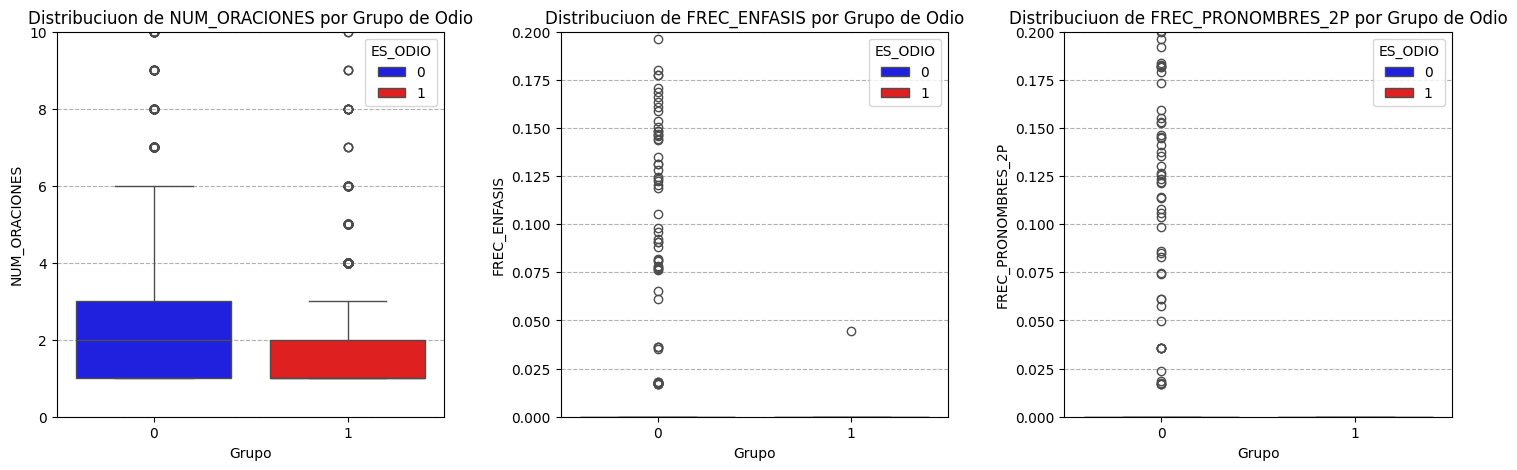

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

metricas = ['NUM_ORACIONES', 'FREC_ENFASIS', 'FREC_PRONOMBRES_2P']

fig, axes = plt.subplots(1,3,figsize=(18,5))
plt.subplots_adjust(wspace=0.3)
y_limits = [10, 0.2, 0.2]

for i, metrica in enumerate(metricas):
    ax = axes[i]
    sns.boxplot(
        x='ES_ODIO',
        y=metrica,
        hue='ES_ODIO',
        data=data,
        palette=['blue', 'red'],
        ax=ax
    )
    ax.set_ylim(0, y_limits[i])
    ax.set_title(f'Distribuciuon de {metrica} por Grupo de Odio')
    ax.set_xlabel('Grupo')
    ax.set_ylabel(metrica)
    ax.grid(axis='y', linestyle='--')

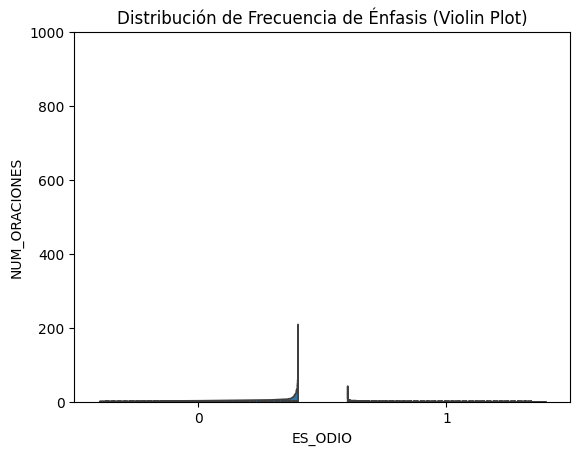

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Usamos FREC_ENFASIS como ejemplo
sns.violinplot(
    x='ES_ODIO', 
    y='NUM_ORACIONES', 
    data=data, 
    hue='ES_ODIO', 
    split=True, # CLAVE: Combina las dos mitades del violín en una sola vista para fácil comparación
    inner='quartile', # Muestra la mediana y los cuartiles dentro del violín
    legend=False
)

# Aplicar el límite Y (es crucial aquí también para ignorar outliers)
plt.ylim(0, 1000) # Asumimos escala decimal (0-10%)
plt.title('Distribución de Frecuencia de Énfasis (Violin Plot)')
plt.show()

In [29]:
doc_problema = doc[i] # El objeto Doc de spaCy
conteo_real = 0
print("--- ORACIONES DETECTADAS POR SPACY ---")
for sent in doc_problema.sents:
    print(f"Oración {conteo_real}: {sent.text}")
    conteo_real += 1
    if conteo_real > 10: # Detener después de 10 para no imprimir 200 líneas
        break

--- ORACIONES DETECTADAS POR SPACY ---
Oración 0: el resultado de políticos ineptos y corruptos, que arruinaron a españa.


<b>Incluye aquí, debajo de la línea, la explicación de tu respuesta</b>
<hr>
 